<h1> Address Reference Service</h1>

## Usage

For **Instant Mode** release:
- `$ python address_validation.py --instant_mode=True --api='googlemaps' --address='400 George Street, Sydney NSW, 2000 New Zealand'`

For **Batch Mode** release:
1) Validation:
`$python address_validation.py --source_system='myserver_1' --source_data='data/address_sample_mockup.csv' --source_metadata='metadata/address_sample_mockup.json' --key='ID' --namespace='myserver.address.sample' --instant_mode=False   --nrows=1 --output_filepath='output/myserver.address.sample.csv' --api='googleapi' -- columns_to_redact=['ADDRESSEE']`

2) Synchronization Rate:
`calc_sync_rate(source=pd.read_csv("source.csv", delimiter=",", nrows=None )["Suggested Address"],                    target=pd.read_csv("target.csv", delimiter=",", nrows=None )["Suggested Address"])`

3) Address Interface Data Analysis:
`analyse_payload(payload_name="payload_sample_source1_to_taget2.json", address_node=["party", "partyLocations", 0, "physicalAddress"], multiple_address_line_kv=True, source_system="Opal", target_system="Salesforce", multiple_line_kv=False,   keys=['addressLine1', 'suburbName', 'stateCode', 'postcode', 'country', 'dPID'], output_include_payload=False)`

4) Address Wash and Clean (scrubbing list of addresses):
`AV.dry_quick(pd.read_csv("output/experian_address_mockup.csv", delimiter=",", nrows=None)["Original address"])`


<H3> Address Data Sample Mockup (original): </H3>
<br>
PARTY_KEY,ADDRESSEE,ADDR_LINE_1,ADDR_LINE_2,ADDR_LINE_3,ADDR_LINE_4,ADDR_LINE_5,ADDR_LINE_6,SUBURB,CITY,STATE_CODE,POST_CODE,COUNTRY_CODE <br>
PK1011571_WRONG_COUNTRY,WRONG_COUNTRY, 243 Baylis St ,Wagga Wagga NSW,,,,,,,,2650,New Zealand <br>
PK1011573_POSTCODE_IN_SUBURB,POSTCODE_IN_SUBURB, 243 Baylis St Wagga Wagga NSW,,,,,,2650,,,,Australia <br>
PK1011575_IN_SINGLE_LINE,IN_SINGLE_LINE, 243 Baylis St Wagga Wagga NSW,,,,,,,,,2650,Australia <br>
PK1011577_MISSING_POSTCODE,MISSING_POSTCODE, 243 Baylis Road Wagga Wagga,,,,,,,,,,Australia <br> 
PK1011579_WRONG_POSTCODE,WRONG_POSTCODE, 243 Baylis Road Wagga Wagga,,,,,,,,,2653,Australia <br>
PK1011581_MISSING_SUBURB,MISSING_SUBURB, 243 Baylis Street,,,,,,,,,2650,Australia <br>
PK1011583_UNKNOWN,UNKNOWN, UNIT 2 43 GOLDERS WAY     GIRRAWHEEN WA,,,,,,,,,6064,Australia <br>
PK1011673_MISSING_ZERO,MISSING_ZERO,49 Wooliana Road Daly River NT,,,,,,,,,822,Australia <br>

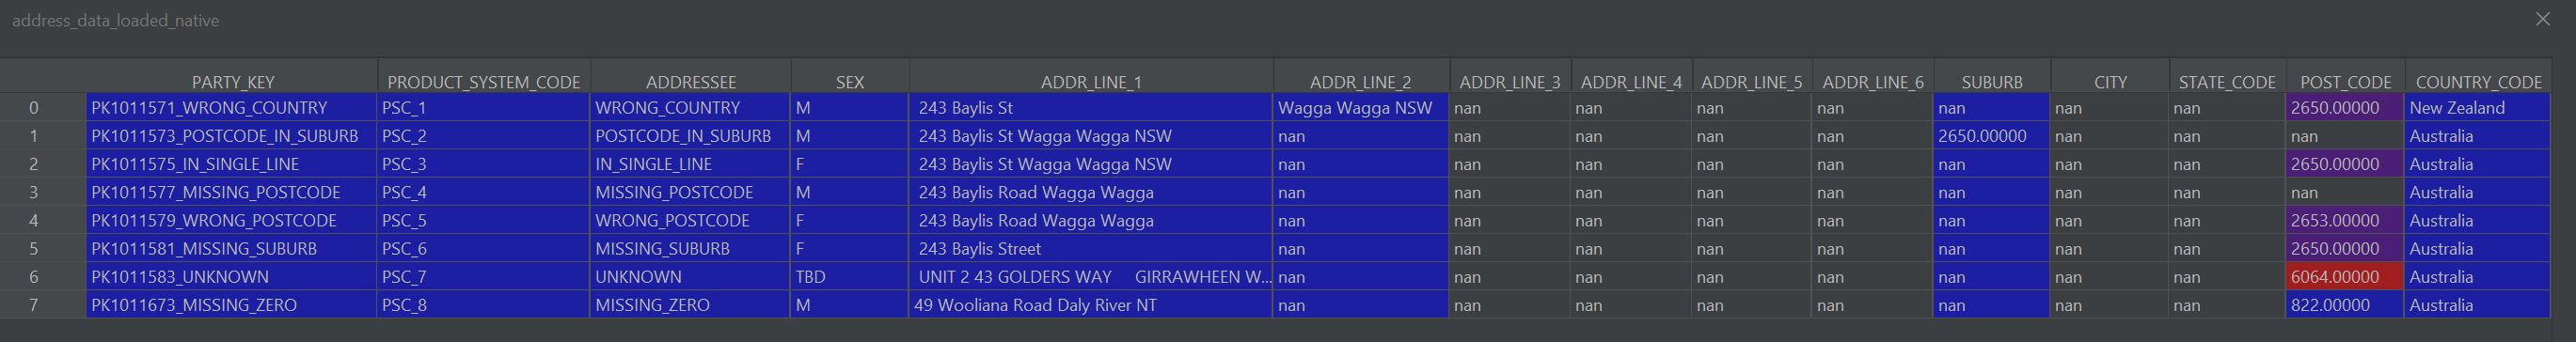 

<h2> Codebase (PoC) </h2>

In [16]:
import os
import sys
import re
import time
import pandas
import yaml
import json
import csv
import pprint
import argparse
import uuid
import logging
import pandas as pd

from address_engine import GoogleMaps, BingMaps, NominatimGeocoder, AusPost
from address_fuzzy_nlp import levenshtein_similarity, calculate_similarity_ml, jaccard_similarity, determine_similarity_level, determine_similarity_level_ml, run_fuzzy
from address_normalization import normalize_address, denormalize_address, lookup_normalized_address_component
from address_standardization import map_to_standard, nomiatium_to_standard, pas_split_address, map_to_original
from address_validation import *

In [2]:
CGoogleMaps = GoogleMaps(api_key=None, base_url=None)
CBingMaps = BingMaps(api_key=None, base_url=None)
CNominatim = NominatimGeocoder(api_key=None, base_url=None)
CAusPost = AusPost(api_key=None, password=None, base_url=None)

In [ ]:
AddressValidation(
    source_data="data/infoperian_address_mockup.csv",
    source_metadata="metadata/infoperian_address_mockup.json",
    key=["PARTY_KEY", "PRODUCT_SYSTEM_CODE"],
    source_system="pas",
    namespace="myserver.address.sample",
    instant_mode=False,
    nrows=None,
    output_filepath="output/infoperian_address_mockup_output.csv",
    api="googlemaps")  # bingmaps, nominatim, auspost

In [11]:
def load_address_metadata(source_metadata):
    message_details = f"Loading address metadata [source_metadata: {source_metadata}]..."
    logger.info(message_details) 
    with open(source_metadata, 'r') as f:
        address_metadata_loaded = json.load(f) 
    message_details = f"\nAddress metadata [{source_metadata}] loaded:\n [{address_metadata_loaded}]"
    return address_metadata_loaded

In [12]:
address_metadata_loaded = load_address_metadata("metadata/experian_address_mockup.json")

In [1]:
def load_address_data(source_data=None, nrows=None):
    message_details = f"Loading address data [Source system: {source_data}..."
    logger.info(message_details) 
    address_data_loaded = pd.read_csv(source_data, delimiter=",", nrows=nrows)
    address_data_loaded.columns = address_data_loaded.columns.str.lower()
    message_details = f"\nAddress data [{source_data}] loaded:\n [{address_data_loaded}]"
    return address_data_loaded

In [9]:
address_data_loaded = load_address_data(source_data="data/experian_address_mockup.csv")
address_data_loaded = address_data_loaded.head(1)
print (address_data_loaded)

   party_key                               addr_line_1  addr_line_2  \
0  PK1011571   UNIT 2 43 GOLDERS WAY     GIRRAWHEEN WA          NaN   

   addr_line_3  addr_line_4  addr_line_5  addr_line_6  suburb  city  \
0          NaN          NaN          NaN          NaN     NaN   NaN   

   state_code  post_code  country_code  
0      6064.0  Australia           NaN  


In [2]:
address_data_loaded

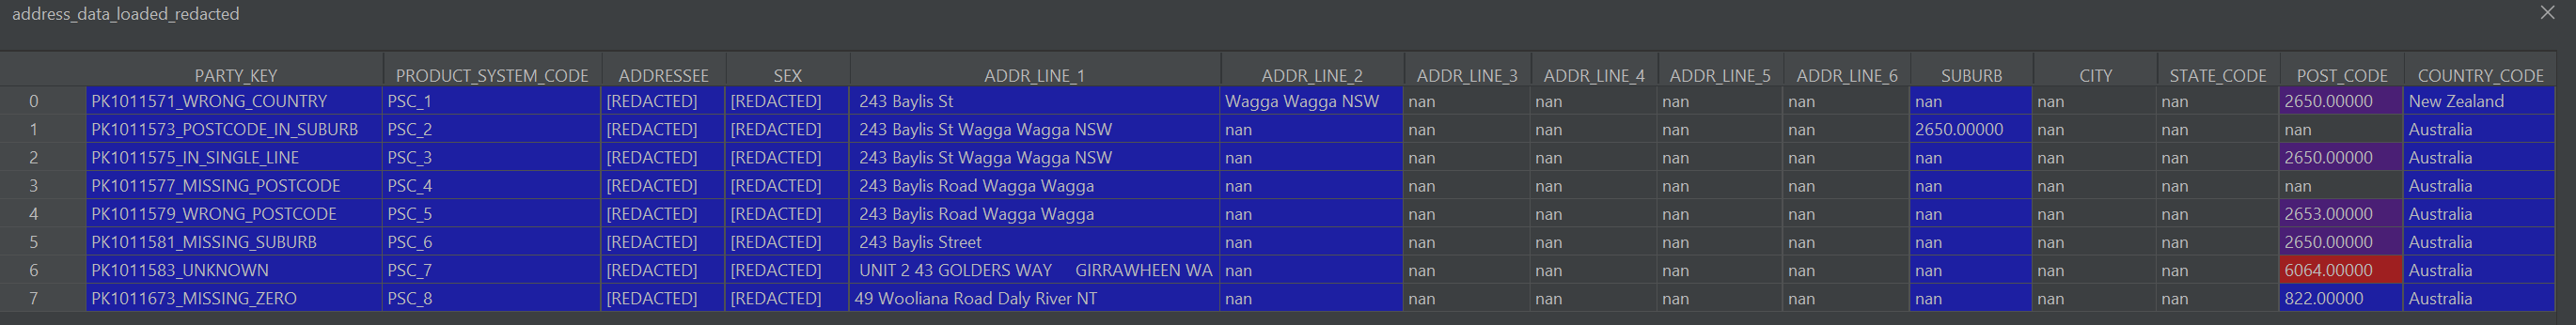

In [13]:
column_mapping = {d['key']: d['value'] for d in address_metadata_loaded['schema']}
address_data_loaded_cmapped = address_data_loaded.rename(columns=column_mapping)
print (address_data_loaded_cmapped)

   party_key                               addr_line_1  addr_line_2  \
0  PK1011571   UNIT 2 43 GOLDERS WAY     GIRRAWHEEN WA          NaN   

   addr_line_3  addr_line_4  addr_line_5  addr_line_6  suburb  city  \
0          NaN          NaN          NaN          NaN     NaN   NaN   

   state_code  post_code  country_code  
0      6064.0  Australia           NaN  


In [14]:
def load_address_component_reference(address_component={"postcode", "conuntry_code", "state", "city", "suburb", "gpid"}):
    message_details = f"Loading address component reference [address_component: {address_component}]..."
    pass

def de_normalize_address(address_data_loaded=None, address_metadata_loaded=None):
    message_details = f"De-normalizing address [address_data_loaded: {address_data_loaded} | address_metadata_loaded: {address_metadata_loaded}]... "
    pass

def normalize_address(address_data_loaded=None, address_metadata_loaded=None):
    address_normalized = ' '.join(
        [str(int(address_data_loaded[field['value']])) if isinstance(address_data_loaded[field['value']], float) else str(address_data_loaded[field['value']])
         for field in ([item for item in address_metadata_loaded['schema'] if item['address_attribute'] == 'yes']) if str(address_data_loaded[field['value']]) != 'nan'])
    return address_normalized

In [15]:
row = address_data_loaded_cmapped

In [16]:
row

,party_key,addr_line_1,addr_line_2,addr_line_3,addr_line_4,addr_line_5,addr_line_6,suburb,city,state_code,post_code,country_code
0,PK1011571,UNIT 2 43 GOLDERS WAY GIRRAWHEEN WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6064.0,Australia,NaN


In [17]:
guid = str(uuid.uuid4())
key = str(row['party_key'])
print (key)

0    PK1011571
Name: party_key, dtype: object


In [18]:
address_normalized = normalize_address(row, address_metadata_loaded)

In [19]:
pprint.pprint (address_normalized)

('0     UNIT 2 43 GOLDERS WAY     GIRRAWHEEN WA\n'
 'Name: addr_line_1, dtype: object 0   NaN\n'
 'Name: addr_line_2, dtype: float64 0   NaN\n'
 'Name: addr_line_3, dtype: float64 0   NaN\n'
 'Name: addr_line_4, dtype: float64 0   NaN\n'
 'Name: addr_line_5, dtype: float64 0   NaN\n'
 'Name: addr_line_6, dtype: float64 0   NaN\n'
 'Name: suburb, dtype: float64 0   NaN\n'
 'Name: city, dtype: float64 0    6064.0\n'
 'Name: state_code, dtype: float64 0    Australia\n'
 'Name: post_code, dtype: object 0   NaN\n'
 'Name: country_code, dtype: float64')


In [20]:
validation_result, suggested_address_from_api, suggested_coordinates_from_api, place_id_from_api, address_components_from_api = CNominatim.validate_address(address_normalized)
print (f"Validation Result (for orginal address before correction): {validation_result}")

Validation Result (for orginal address before correction): Invalid


In [22]:
suggestion_result_api, suggested_address_from_api, suggested_coordinates_from_api, place_id_from_api, address_components_from_api = CGoogleMaps.suggest_address(address_normalized)
print (f"Validation Result (for suggested address after correction): {suggestion_result_api}")

Validation Result (for suggested address after correction): Valid


In [23]:
print (f"Suggested Address: {suggested_address_from_api}")

Suggested Address: 0 2/43 Golders Way, Girrawheen WA 6064, Australia


In [24]:
print (f"Suggested Coordinates: {suggested_coordinates_from_api}")

Suggested Coordinates: {-31.8480871: 115.8539407}


In [25]:
print(f"Suggested Address Components:")
pprint.pprint(address_components_from_api, sort_dicts=False)

Suggested Address Components:
[{'long_name': '0 2', 'short_name': '0 2', 'types': ['subpremise']},
 {'long_name': '43', 'short_name': '43', 'types': ['street_number']},
 {'long_name': 'Golders Way', 'short_name': 'Golders Way', 'types': ['route']},
 {'long_name': 'Girrawheen',
  'short_name': 'Girrawheen',
  'types': ['locality', 'political']},
 {'long_name': 'City of Wanneroo',
  'short_name': 'Wanneroo',
  'types': ['administrative_area_level_2', 'political']},
 {'long_name': 'Western Australia',
  'short_name': 'WA',
  'types': ['administrative_area_level_1', 'political']},
 {'long_name': 'Australia',
  'short_name': 'AU',
  'types': ['country', 'political']},
 {'long_name': '6064', 'short_name': '6064', 'types': ['postal_code']}]


In [26]:
"""Fuzzy"""
similarity_ratio = levenshtein_similarity(source=address_normalized, target=suggested_address_from_api)
similarity_level = determine_similarity_level(similarity_ratio)
print (f"Similarity Ratio (using Levenshtein fuzzy logic): {similarity_ratio}  Similarity Level: {similarity_level}")

Similarity Ratio (using Levenshtein fuzzy logic): 17  Similarity Level: Different


In [27]:
similarity_ratio = jaccard_similarity(source=address_normalized, target=suggested_address_from_api)
similarity_level = determine_similarity_level(similarity_ratio)
print (f"Similarity Ratio (using Jaccard fuzzy logic): {similarity_ratio}  Similarity Level: {similarity_level}")

Similarity Ratio (using Jaccard fuzzy logic): 44.89795918367347  Similarity Level: Different


In [4]:
# standard_address_map_googlemap 
{
   "googlemaps_to_standard": [
      {
         "key": "street_number",
         "value": "street_number"
      },
      {
         "key": "street",
         "value": "street"
      },
      {
         "key": "suburb",
         "value": "suburb"
      },
      {
         "key": "political",
         "value": "political"
      },
      {
         "key": "city",
         "value": "city"
      },
      {
         "key": "state",
         "value": "state"
      },
      {
         "key": "country",
         "value": "country"
      },
      {
         "key": "postal_code",
         "value": "postal_code"
      }
   ],
   "standard_to_minerva": [
      {
         "key": "street_number",
         "value": "line1"
      },
      {
         "key": "street",
         "value": "line2"
      },
      {
         "key": "suburb",
         "value": "suburb"
      },

      {
         "key": "state",
         "value": "state"
      },
      {
         "key": "country",
         "value": "country"
      },
      {
         "key": "postal_code",
         "value": "post_code"
      }
   ],   
   "standard_to_pas_split": [
      {
         "key": "street_number",
         "value": "field_1"
      },
      {
         "key": "street",
         "value": "field_1"
      },
      {
         "key": "suburb",
         "value": "field_2"
      },
      {
         "key": "state",
         "value": "field_3"
      },
      {
         "key": "country",
         "value": "country"
      },
      {
         "key": "postal_code",
         "value": "post_code"
      }
   ],
   "standard_to_cmdm": [
      {
         "key": "street_number",
         "value": "street number"
      },
      {
         "key": "street",
         "value": "street"
      },
      {
         "key": "suburb",
         "value": "suburb"
      },
      {
         "key": "state",
         "value": "state"
      },
      {
         "key": "country",
         "value": "country"
      },
      {
         "key": "postal_code",
         "value": "post_code"
      }
   ],
   "standard_to_salesforce": [
      {
         "key": "street",
         "value": "street"
      },
      {
         "key": "suburb",
         "value": "suburb"
      },
      {
         "key": "city",
         "value": "city"
      },
      {
         "key": "state",
         "value": "state"
      },
      {
         "key": "country",
         "value": "country"
      },
      {
         "key": "postal_code",
         "value": "post_code"
      }
   ]
}


In [189]:
from address_standardization import googlemap_to_standard
googlemap_converted_to_standard = map_to_standard(address_from_googlemap_api=address_components_from_api, standard=True)
message_details = f"\nSuggested address converted to standard address format:"
print(message_details)
pprint.pprint(googlemap_converted_to_standard, sort_dicts=False)


Suggested address converted to standard address format:
{'street_number': '43',
 'street': 'Golders Way',
 'subpremise': '0 2',
 'suburb': 'Girrawheen',
 'political': 'Australia',
 'city': 'City of Wanneroo',
 'state': 'Western Australia',
 'country': 'Australia',
 'postal_code': '6064'}


In [190]:
""" Standard To Original (Minerva)"""
converted_back_to_original_minerva = map_to_original(data=googlemap_converted_to_standard,
                                                                             metadata='metadata/standard_address_map_googlemaps.json',
                                                                             node_in_metadata='standard_to_minerva',
                                                                             combined_street_address=False)
message_details = f"\nStandard address format converted back to the original format [standard_to_minerva]:"
print(message_details)
pprint.pprint(converted_back_to_original_minerva, sort_dicts=False)


Standard address format converted back to the original format [standard_to_minerva]:
{'line1': '43',
 'line2': 'Golders Way',
 'suburb': 'Girrawheen',
 'state': 'Western Australia',
 'country': 'Australia',
 'post_code': '6064'}


In [191]:
""" Standard To Original (PAS)"""
converted_back_to_original_pas_split = pas_split_address(suggested_address_from_api)
message_details = f"\nStandard address format converted back to the original format [standard_to_pas]:"
print(message_details)
pprint.pprint(converted_back_to_original_pas_split, sort_dicts=False)


Standard address format converted back to the original format [standard_to_pas]:
{'address_line_1': '0 2/43 Golders Way,',
 'address_line_2': 'Girrawheen WA 6064, Australia'}


In [192]:
""" Standard To Original (CMDM)"""
converted_back_to_original_cmdm = map_to_original(data=googlemap_converted_to_standard,
                                                                          metadata='metadata/standard_address_map_googlemaps.json',
                                                                          node_in_metadata='standard_to_cmdm',
                                                                          combined_street_address=False)
message_details = f"\nStandard address format converted back to the original format [standard_to_cmdm]:"
print(message_details)
pprint.pprint(converted_back_to_original_cmdm, sort_dicts=False)


Standard address format converted back to the original format [standard_to_cmdm]:
{'street number': '43',
 'street': 'Golders Way',
 'suburb': 'Girrawheen',
 'state': 'Western Australia',
 'country': 'Australia',
 'post_code': '6064'}


In [193]:
converted_back_to_original_sf = map_to_original(data=googlemap_converted_to_standard,
                                                                        metadata='metadata/standard_address_map_googlemaps.json',
                                                                        node_in_metadata='standard_to_salesforce',
                                                                        combined_street_address=True)
message_details = f"\nStandard address format converted back to the original format [standard_to_salesforce]:"
print(message_details)
pprint.pprint(converted_back_to_original_sf, sort_dicts=False)


Standard address format converted back to the original format [standard_to_salesforce]:
{'street': '43 Golders Way',
 'suburb': 'Girrawheen',
 'city': 'City of Wanneroo',
 'state': 'Western Australia',
 'country': 'Australia',
 'post_code': '6064'}


In [5]:
validation_result_bundled = {
                        "KEY": value_in_key_column,
                        "Original address": address_normalized_original,
                        "Validation Result": validation_result,
                        "Suggested Address": suggested_address_from_api if post_box is None else f'{post_box} {suggested_address_from_api}',
                        "Invalid street number/address": str(invalid_street_address),

                        "Similarity Ratio": similarity_ratio,
                        "Similarity Level": similarity_level,

                        "Suggested Coordinates": suggested_coordinates_from_api,
                        "Suggested Place ID": place_id_from_api,
                        "Suggested DPID": "TBD",
                        "converted_back_to_original_SYD_pas_split": converted_back_to_original_pas_split,
                        # "converted_back_to_original_pas": converted_back_to_original_pas,
                        "converted_back_to_original_sf": converted_back_to_original_sf,
                        "converted_back_to_original_cmdm": converted_back_to_original_cmdm,
                        "converted_back_to_original_minerva": converted_back_to_original_minerva,

                        "Column Name Key": self.key,
                        "Column Name Value": column_name_as_value,
                        "GUID": guid,  # str(uuid.uuid4())
                        "Namespace": self.namespace,
                        "Source System": self.source_system,
                        "Source Data": self.source_data,
                        "Source Metadata": self.source_metadata,
                        "Instant Mode": str(self.instant_mode),
                        "API Service": str(self.api),
                        "Note": "Nominatim API does not provide 'street number' so mapping back to original is not accurate. Use googlemaps/bingmaps API instead." if str(self.api) == "nominatim" else "None"
                    }

In [ ]:
{
    "KEY": "PK1011571_WRONG_COUNTRY|PSC_1",
    "ORIGINAL ADDRESS": " 243 Baylis St  Wagga Wagga NSW 2650 New Zealand",
    "VALIDATION RESULT": "Invalid",
    "SUGGESTED ADDRESS": "243 Baylis St, Wagga Wagga NSW 2650, Australia",
    "INVALID STREET NUMBER/ADDRESS": "False",
    "SIMILARITY RATIO": 83,
    "SIMILARITY LEVEL": "Very similar, with only minor differences",
    "SUGGESTED COORDINATES": {
        "-35.109307": "147.3714238"
    },
    "SUGGESTED PLACE ID": "ChIJBfW_iYCZGGsRF5WC58CyI8Y",
    "SUGGESTED DPID": "TBD",
    "CONVERTED_BACK_TO_ORIGINAL_SYD_PAS_SPLIT": {
        "address_line_1": "243 Baylis St, Wagga",
        "address_line_2": "Wagga NSW 2650, Australia"
    },
    "CONVERTED_BACK_TO_ORIGINAL_SF": {
        "street": " 243  Baylis Street",
        "suburb": "Wagga Wagga",
        "city": "Wagga Wagga City Council",
        "state": "New South Wales",
        "country": "Australia",
        "post_code": "2650"
    },
    "CONVERTED_BACK_TO_ORIGINAL_CMDM": {
        "street number": "243",
        "street": "Baylis Street",
        "suburb": "Wagga Wagga",
        "state": "New South Wales",
        "country": "Australia",
        "post_code": "2650"
    },
    "CONVERTED_BACK_TO_ORIGINAL_MINERVA": {
        "line1": "243",
        "line2": "Baylis Street",
        "suburb": "Wagga Wagga",
        "state": "New South Wales",
        "country": "Australia",
        "post_code": "2650"
    },
    "COLUMN NAME KEY": [
        "PARTY_KEY",
        "PRODUCT_SYSTEM_CODE"
    ],
    "COLUMN NAME VALUE": [
        "party_key",
        "product_system_code"
    ],
    "GUID": "67053fb9-a003-4ebe-8eb1-78bdfb6a9f15",
    "NAMESPACE": "infoperian.test.rla.com.au",
    "SOURCE SYSTEM": "infoperian",
    "SOURCE DATA": "data/infoperian_address_mockup.csv",
    "SOURCE METADATA": "metadata/infoperian_address_mockup.json",
    "INSTANT MODE": "False",
    "API SERVICE": "googlemaps",
    "NOTE": "None"
}

In [195]:
key_place_id_mapped = {
                        "GUID": guid,
                        "Key": key,
                        "Key Name": "self.key",
                        "Namespace": "self.namespace",
                        "Place ID": place_id_from_api,
                        "Address": suggested_address_from_api,
                        "Address Components": address_components_from_api,
                        "API Service": "str(self.api)"
                    }
pprint.pprint (key_place_id_mapped, sort_dicts=False)

{'GUID': '503d2082-fc12-47a0-9c6a-b6cc749e3033',
 'Key': '0    1011571\nName: party_key, dtype: int64',
 'Key Name': 'self.key',
 'Namespace': 'self.namespace',
 'Place ID': 'EjEwIDIvNDMgR29sZGVycyBXYXksIEdpcnJhd2hlZW4gV0EgNjA2NCwgQXVzdHJhbGlhIh8aHQoWChQKEgkjij9L4LEyKhGk-EjQIT3E2xIDMCAy',
 'Address': '0 2/43 Golders Way, Girrawheen WA 6064, Australia',
 'Address Components': [{'long_name': '0 2',
                         'short_name': '0 2',
                         'types': ['subpremise']},
                        {'long_name': '43',
                         'short_name': '43',
                         'types': ['street_number']},
                        {'long_name': 'Golders Way',
                         'short_name': 'Golders Way',
                         'types': ['route']},
                        {'long_name': 'Girrawheen',
                         'short_name': 'Girrawheen',
                         'types': ['locality', 'political']},
                        {'long_name': 'C

<h2>Address Components Enrichment - LLM (Instant Mode) </h2>

In [20]:
AddressValidation(address="U 4 177 ,,West Coast Hwy,,,,SCARBOROUGH,,WA,6019,AUSTRALIA", instant_mode=True, api="googlemaps")  # nominatim, googlemaps, bingmaps

{ <br>
    "GUID": "95033540-031d-4098-89e5-eaa986c84ee1", <br>
    "Original address": "U 4 177 ,,West Coast Hwy,,,,SCARBOROUGH,,WA,6019,AUSTRALIA",<br>
    "Validation Result": "Invalid",<br>
    "Suggested Address": "U 4/177 W Coast Hwy, Scarborough WA 6019, Australia",<br>
    "Similarity Ratio": 91,<br>
    "Similarity Level": "Identical",<br>
    "API Converted to Standard": "api_converted_to_standard for Googlemap for now",<br>
    "Instant Mode": "True",<br>
    "API Service": "googlemaps",<br>
    "Note": "None",<br>
    "Google Maps": "<a ref=\"https://www.google.com/maps/place/U+4%2F177+W+Coast+Hwy%2C+Scarborough+WA+6019%2C+Australia\">Google Maps</a>",<br>
    "GTP Workbook (LLM)": "This address is for a two-bedroom apartment located in the suburb of Scarborough in the city of Perth, Western Australia<br> The apartment is located on the fourth floor of a five-story building<br> It is within walking distance to the beach and to the Scarborough Beachfront Precinct, which offers a variety of shops, restaurants, and entertainment<br> The area is also close to public transportation, making it convenient for commuters<br> The apartment is located in a quiet and safe neighborhood, and is surrounded by parks and green spaces", <br>
}

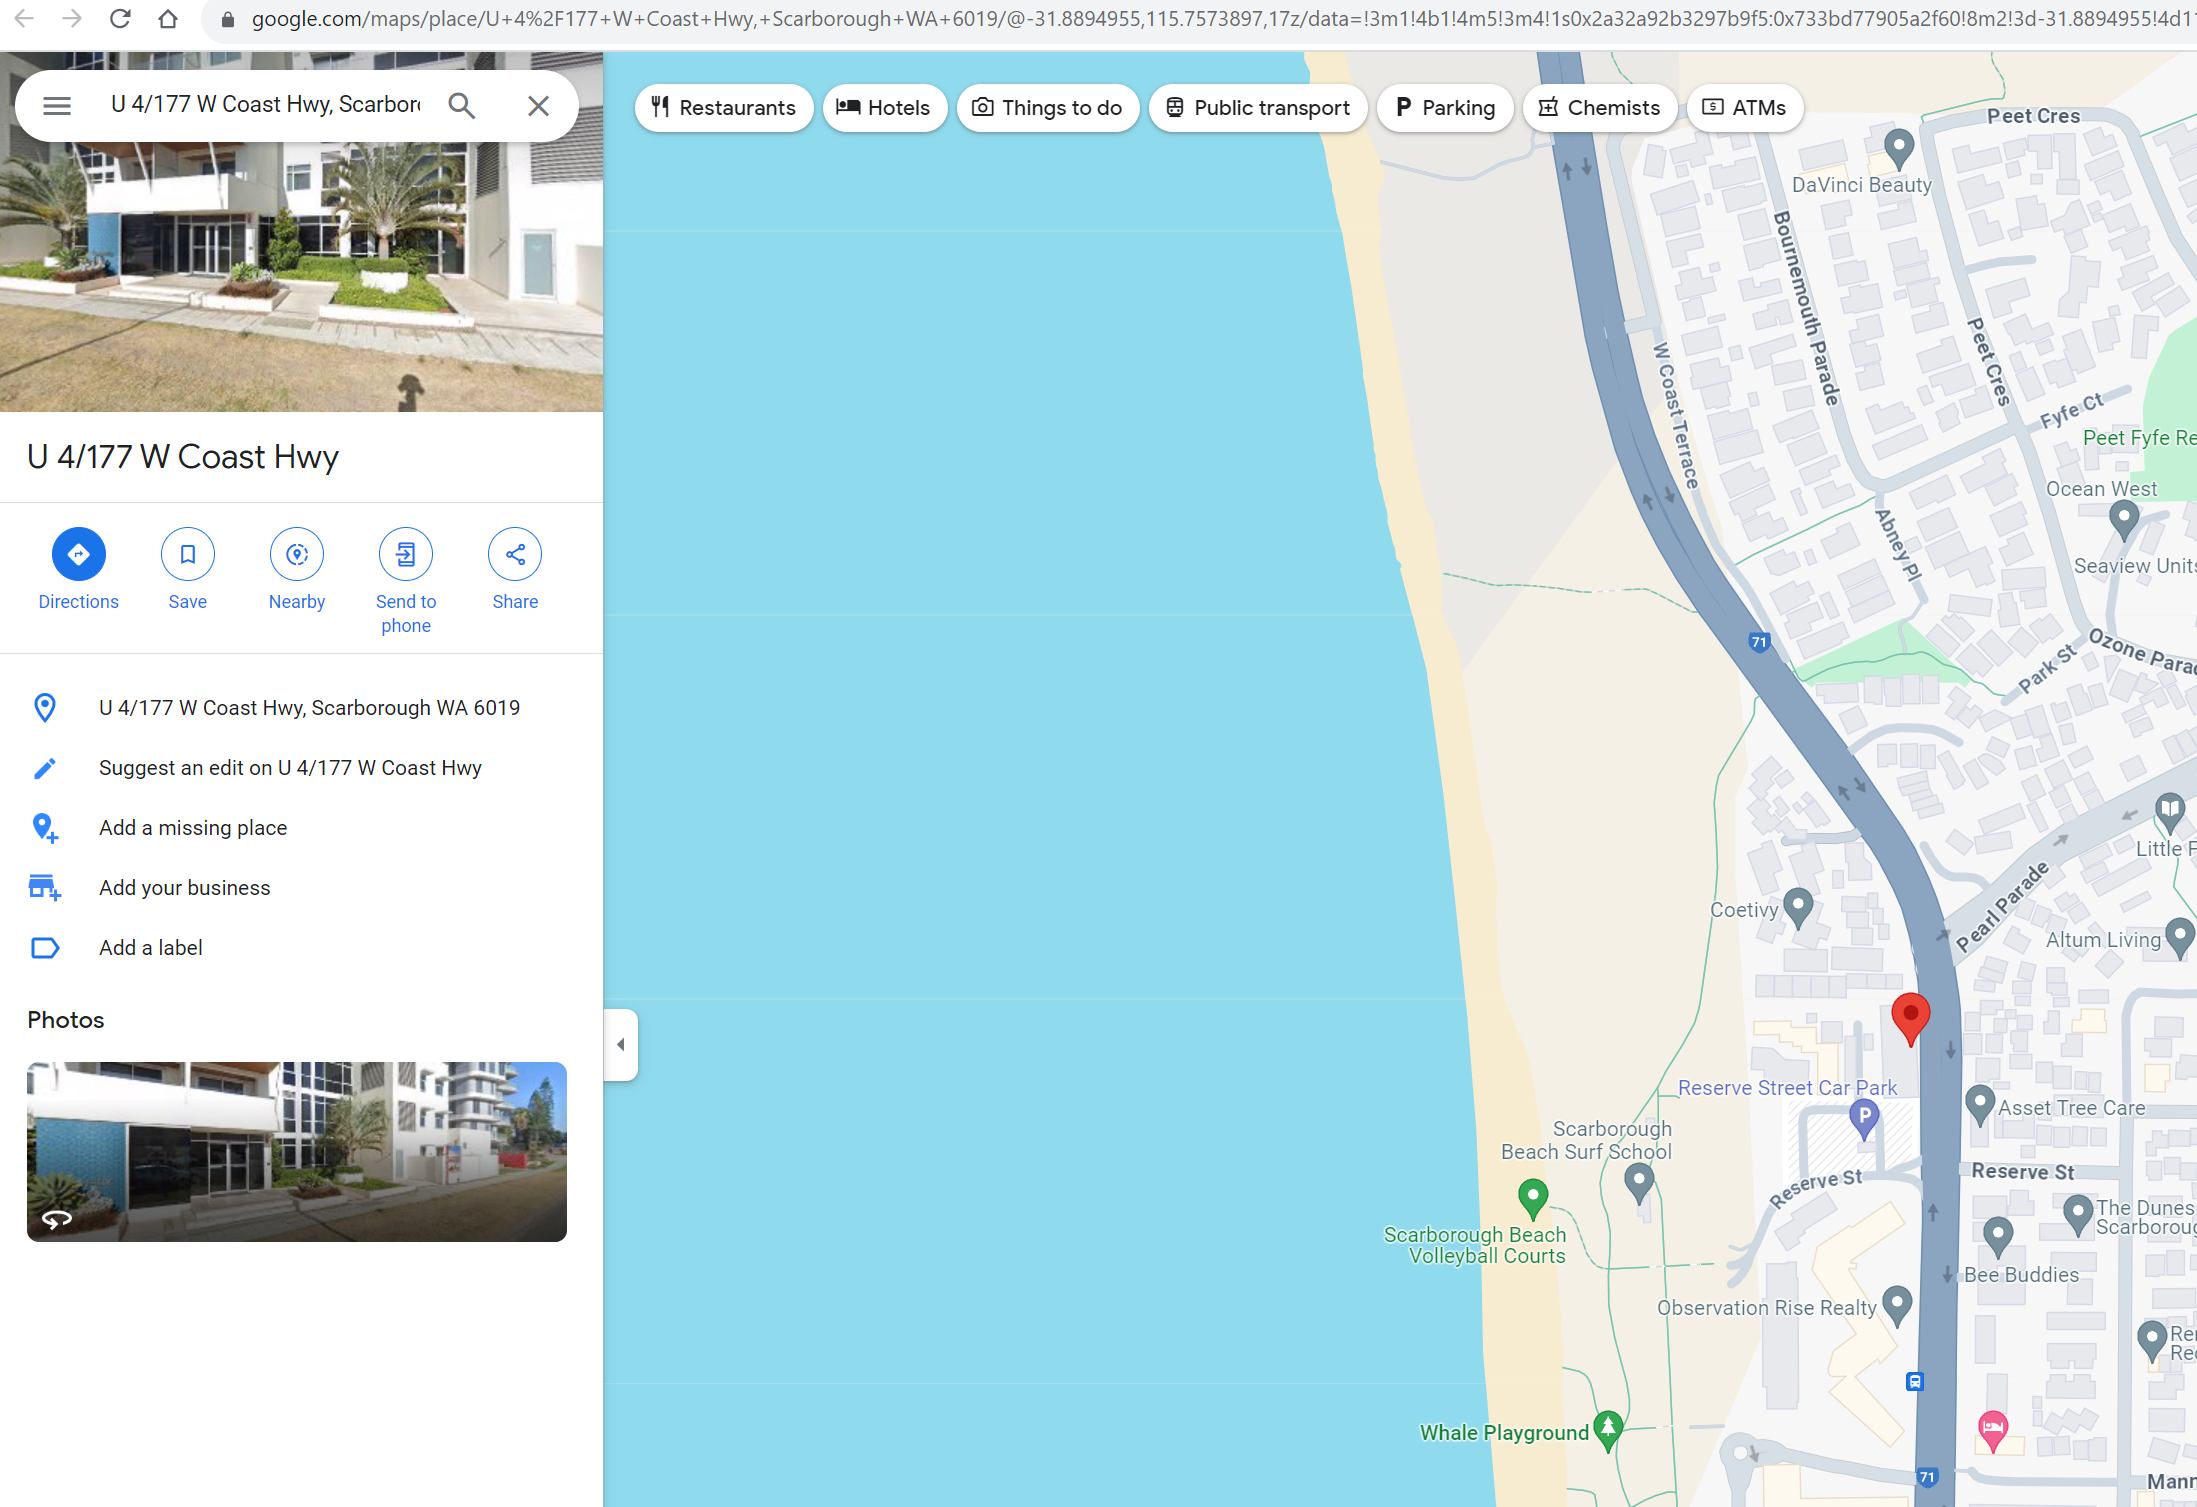

<h2>Address Sync Data Analysis</h2>

In [214]:
x=AddressSyncAnalyser(api_type="json")
x.analyse_payload(payload_name="metadata/payload/payload_sample_opal.json",
                                address_node=["item", 2, "request", "body", "raw"],
                                multiple_address_line_kv=False,
                                source_system="Opal",
                                target_system="Salesforce",
                                multiple_line_kv=False,
                                keys=['Street1', 'Suburb', 'StateCode', 'PostCode', 'CountryCode'],
                                output_include_payload=False)

### Payload (payload_sample_opap.json)
{
	"// comment": "https://rlaanz.atlassian.net/wiki/spaces/CFDDP/pages/136381132/Technical+Details",
	"info": {

		"_postman_id": "74e500da-142c-4c79-b4c4-3b83f2e63e7b",
		"name": "OPALS API",
		"schema": "https://schema.getpostman.com/json/collection/v2.1.0/collection.json",
		"_exporter_id": "20987646"
	},
	"item": [
		{
			"name": "Get Party Address",
			"request": {
				"method": "GET",
				"header": [],
				"url": {
					"raw": "https://rlgsl-dev.outsystemsenterprise.com/Party_API/rest/v1/PartyAddress?AddressTypeCode=BUS&Scv=7937056097",
					"protocol": "https",
					"host": [
						"rlgsl-dev",
						"outsystemsenterprise",
						"com"
					],
					"path": [
						"Party_API",
						"rest",
						"v1",
						"PartyAddress"
					],
					"query": [
						{
							"key": "AddressTypeCode",
							"value": "BUS"
						},
						{
							"key": "Scv",
							"value": "7937056097"
						}
					]
				}
			},
			"response": []
		},
		{
			"name": "Get Person",
			"request": {
				"method": "GET",
				"header": [],
				"url": {
					"raw": "https://rlgsl-dev.outsystemsenterprise.com/Party_API/rest/v1/Person?Scv=8630036786",
					"protocol": "https",
					"host": [
						"rlgsl-dev",
						"outsystemsenterprise",
						"com"
					],
					"path": [
						"Party_API",
						"rest",
						"v1",
						"Person"
					],
					"query": [
						{
							"key": "Scv",
							"value": "8630036786"
						}
					]
				}
			},
			"response": []
		},
		{
			"name": "Update Party Address",
			"request": {
				"method": "PUT",
				"header": [],
				"body": {
					"mode": "raw",
					"raw": "{\r\n    \"Id\": 119,\r\n    \"Street1\": \"125 Sydney Road\",\r\n    \"Suburb\": \"Kelso\",\r\n    \"CountryCode\": \"AU\",\r\n    \"StateCode\": \"NSW\",\r\n    \"PostCode\": \"2795\"\r\n}",
					"options": {
						"raw": {
							"language": "json"
						}
					}
				},
				"url": {
					"raw": "https://rlgsl-dev.outsystemsenterprise.com/Party_API/rest/v1/PartyAddress?Scv=8630036786",
					"protocol": "https",
					"host": [
						"rlgsl-dev",
						"outsystemsenterprise",
						"com"
					],
					"path": [
						"Party_API",
						"rest",
						"v1",
						"PartyAddress"
					],
					"query": [
						{
							"key": "Scv",
							"value": "8630036786"
						}
					]
				}
			},
			"response": []
		},
		{
			"name": "Update Person",
			"request": {
				"method": "PUT",
				"header": [],
				"body": {
					"mode": "raw",
					"raw": "{\r\n    \"Id\": 25824,\r\n    \"Email\": \"given.name@domainname.com.au\",\r\n    \"Phone\": \"+61 2 1123 1111\",\r\n    \"MobilePhone\": \"+61 411 111 111\"\r\n}",
					"options": {
						"raw": {
							"language": "json"
						}
					}
				},
				"url": {
					"raw": "https://rlgsl-dev.outsystemsenterprise.com/Party_API/rest/v1/Person?Scv=8630036786",
					"protocol": "https",
					"host": [
						"rlgsl-dev",
						"outsystemsenterprise",
						"com"
					],
					"path": [
						"Party_API",
						"rest",
						"v1",
						"Person"
					],
					"query": [
						{
							"key": "Scv",
							"value": "8630036786"
						}
					]
				}
			},
			"response": []
		}
	],
	"auth": {
		"type": "bearer",
		"bearer": [
			{
				"key": "token",
				"value": "eyJhbGciOiJSUzI1NiIsImtpZCI6IjBJVlcxRUNmVi1GTDJ5WUItWFRTbVVhcXJVRSIsInBpLmF0bSI6ImU4ZTkifQ.eyJzY29wZSI6Im9wZW5pZCBwcm9maWxlIiwiY2xpZW50X2lkIjoic3RhZmZfcG9ydGFsIiwiQUdHVUlEIjoiakFkb3NtVzIyMm80UkZRWUl6eWFjcFRiZU1HaURqSnkiLerwefdssdfsdfsdfOaRKBvtwIo2XUDgkgForiFNAk9HEhWrkPGfVoyMVHbIRdtMcS9dywwTUuoO5V7z0DeVqx7bOYZm5uB1EoIooj_UBD45LyzJPSKI3r3Yg1SOR1jwGVkkXp92oP2mrTsGJHzzXHWMkEFst68adYEHO3R7QjhYetJLLNL_9MMXCgV1oLnh4yW9ECYzwlMLeRw",
				"type": "string"
			}
		]
	},
	"event": [
		{
			"listen": "prerequest",
			"script": {
				"type": "text/javascript",
				"exec": [
					""
				]
			}
		},
		{
			"listen": "test",
			"script": {
				"type": "text/javascript",
				"exec": [
					""
				]
			}
		}
	]
}

In [4]:
# Sync Analysis Results:
{
    "Source System": "Opal",
    "Target System": "Salesforce",
    "address_from_api_payload": {
        "Id": 119,
        "Street1": "125 Sydney Road",
        "Suburb": "Kelso",
        "CountryCode": "AU",
        "StateCode": "NSW",
        "PostCode": "2795"
    },
    "address_normalized": "125 Sydney Road, Kelso, AU, NSW, 2795",
    "validation_result": "Valid",
    "suggested_address_from_api": "125 Sydney Rd, Kelso NSW 2795, Australia",
    "converted_back_to_original_pas_split": {
        "address_line_1": "125 Sydney Rd, Kelso NSW ",
        "address_line_2": "2795,"
    },
    "converted_back_to_original_sf": {
        "street": " 125  Sydney Road",
        "suburb": "Kelso",
        "city": "Bathurst Regional Council",
        "state": "New South Wales",
        "country": "Australia",
        "post_code": "2795"
    },
    "suggested_coordinates_from_api": {
        "-33.4200062": 149.6134417
    },
    "place_id_from_api": "ChIJt1LwfvfkEWsRWjOeWVccHQ4",
    "address_components_from_api": [
        {
            "long_name": "125",
            "short_name": "125",
            "types": [
                "street_number"
            ]
        },
        {
            "long_name": "Sydney Road",
            "short_name": "Sydney Rd",
            "types": [
                "route"
            ]
        },
        {
            "long_name": "Kelso",
            "short_name": "Kelso",
            "types": [
                "locality",
                "political"
            ]
        },
        {
            "long_name": "Bathurst Regional Council",
            "short_name": "Bathurst Regional",
            "types": [
                "administrative_area_level_2",
                "political"
            ]
        },
        {
            "long_name": "New South Wales",
            "short_name": "NSW",
            "types": [
                "administrative_area_level_1",
                "political"
            ]
        },
        {
            "long_name": "Australia",
            "short_name": "AU",
            "types": [
                "country",
                "political"
            ]
        },
        {
            "long_name": "2795",
            "short_name": "2795",
            "types": [
                "postal_code"
            ]
        }
    ],
    "address_payload_processing": "Excluded (data/payload/payload_sample_opal.json)"
}


{'Source System': 'Opal',
 'Target System': 'Salesforce',
 'address_from_api_payload': {'Id': 119,
  'Street1': '125 Sydney Road',
  'Suburb': 'Kelso',
  'CountryCode': 'AU',
  'StateCode': 'NSW',
  'PostCode': '2795'},
 'address_normalized': '125 Sydney Road, Kelso, AU, NSW, 2795',
 'validation_result': 'Valid',
 'suggested_address_from_api': '125 Sydney Rd, Kelso NSW 2795, Australia',
 'converted_back_to_original_pas_split': {'address_line_1': '125 Sydney Rd, Kelso NSW ',
  'address_line_2': '2795,'},
 'converted_back_to_original_sf': {'street': ' 125  Sydney Road',
  'suburb': 'Kelso',
  'city': 'Bathurst Regional Council',
  'state': 'New South Wales',
  'country': 'Australia',
  'post_code': '2795'},
 'suggested_coordinates_from_api': {'-33.4200062': 149.6134417},
 'place_id_from_api': 'ChIJt1LwfvfkEWsRWjOeWVccHQ4',
 'address_components_from_api': [{'long_name': '125',
   'short_name': '125',
   'types': ['street_number']},
  {'long_name': 'Sydney Road', 'short_name': 'Sydney Rd',

<h2> Restful API (idea) </h2>

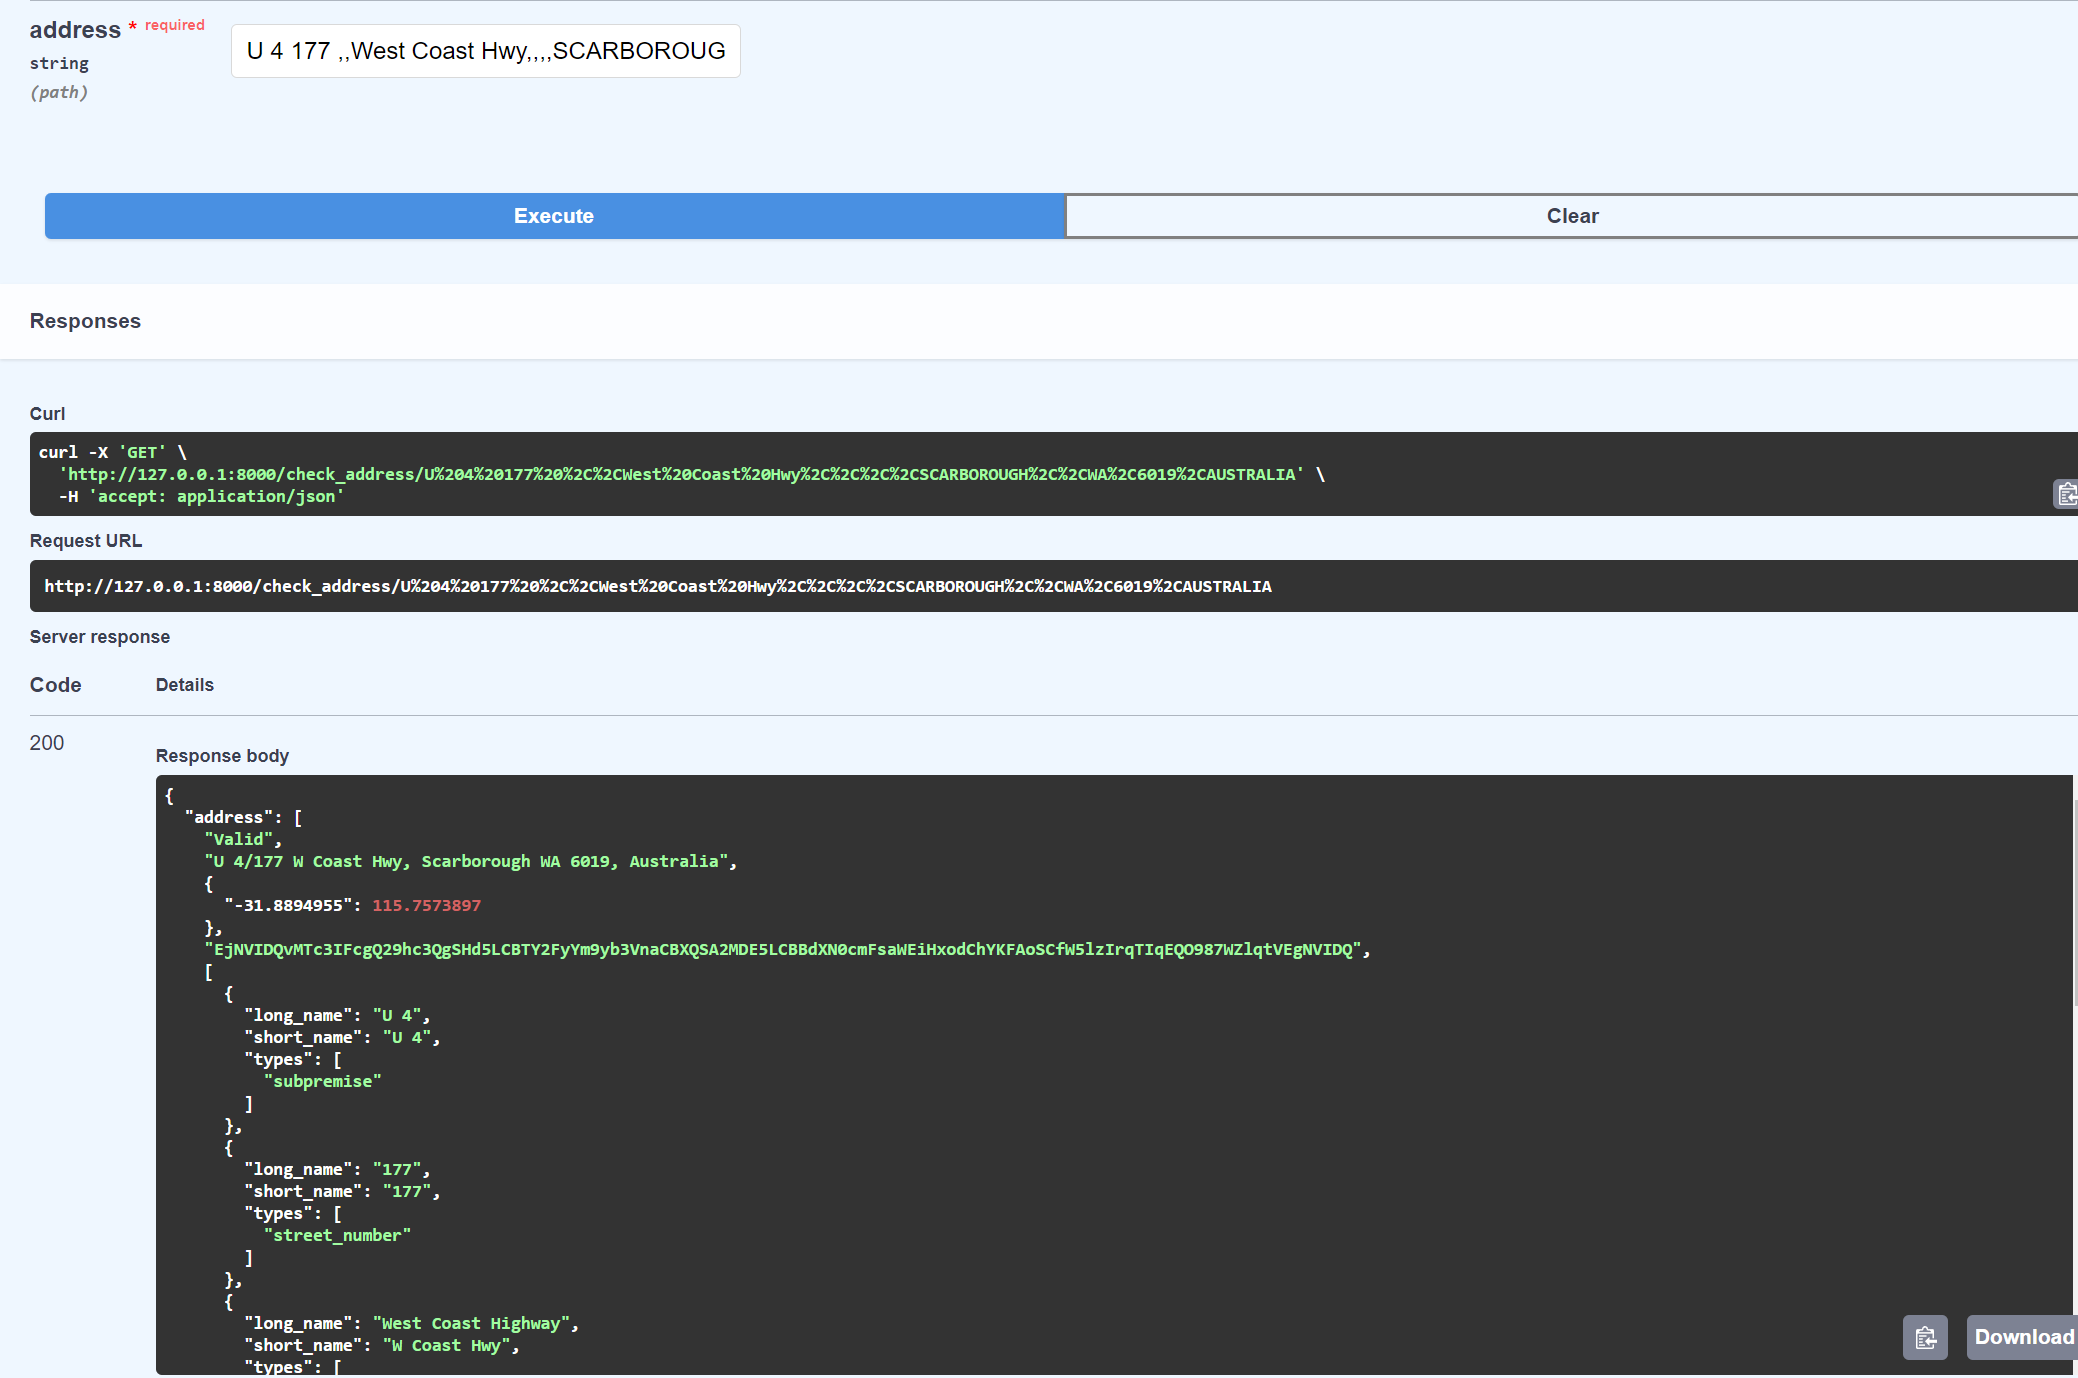